# System Learning Example

We observe trajectories of the FitzHugh-Nagumo Oscillator and we attempt to learn the system dynamics using the `auto_koopman` function. We generate a training set by sampling $n$ random states uniformly and simulating the system over a time horizon. We learn the system, and test against a new initial value.

In [22]:
# the notebook imports
import matplotlib.pyplot as plt
import numpy as np

# this is the convenience function
from autokoopman import auto_koopman

In [23]:
# for a complete example, let's create an example dataset using an included benchmark system
import autokoopman.benchmark.fhn as fhn
fhn = fhn.FitzHughNagumo()
training_data = fhn.solve_ivps(
    initial_states=np.random.uniform(low=-2.0, high=2.0, size=(10, 2)),
    tspan=[0.0, 10.0],
    sampling_period=2
)

In [24]:
# learn model from data
experiment_results = auto_koopman(
    training_data,          # list of trajectories
    sampling_period=0.1,    # sampling period of trajectory snapshots
    obs_type="rff",         # use Random Fourier Features Observables
    opt="grid",             # grid search to find best hyperparameters
    n_obs=200,              # maximum number of observables to try
    max_opt_iter=200,       # maximum number of optimization iterations
    grid_param_slices=5,   # for grid search, number of slices for each parameter
    n_splits=5,             # k-folds validation for tuning, helps stabilize the scoring
    rank=(1, 200, 40)       # rank range (start, stop, step) DMD hyperparameter
)

 80%|████████████████████████████████████         | 4/5 [00:00<00:00, 18.66it/s]


In [25]:
# get the model from the experiment results
model = experiment_results['tuned_model']

# simulate using the learned model
iv = [0.5, 0.1]
trajectory = model.solve_ivp(
    initial_state=iv,
    tspan=(0.0, 10.0),
    sampling_period=0.1
)

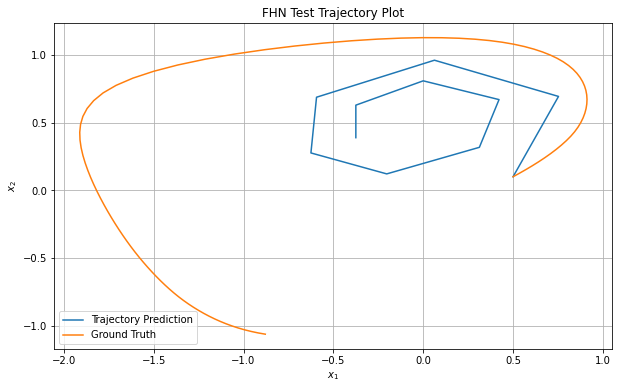

In [26]:
# simulate the ground truth for comparison
true_trajectory = fhn.solve_ivp(
    initial_state=iv,
    tspan=(0.0, 10.0),
    sampling_period=0.1
)

plt.figure(figsize=(10, 6))

# plot the results
plt.plot(*trajectory.states.T, label='Trajectory Prediction')
plt.plot(*true_trajectory.states.T, label='Ground Truth')

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid()
plt.legend()
plt.title("FHN Test Trajectory Plot")
plt.show()

## System with Inputs Learning Example

We observe a pendulum system with an input--constant torque. To make the training data, we sample random states as well as *random step function input signals*. We use the same `auto_koopman` function as before, but we pass in the input signals. 

In [6]:
from autokoopman.benchmark.pendulum import PendulumWithInput

# create the pendulum system
pendulum_sys = PendulumWithInput(beta=0.05)

def make_input_step(duty, on_amplitude, off_amplitude, teval):
    """produce a step response input signal for the pendulum"""
    length = len(teval)
    inp = np.zeros((length,))
    phase_idx = int(length * duty)
    inp[:phase_idx] = on_amplitude
    inp[phase_idx:] = off_amplitude
    return inp

In [7]:
#  training data
teval = np.linspace(0, 10, 200)
params = np.random.rand(10, 3) * 2 - 1
ivs = np.random.rand(10, 2) * 2 - 1
steps = [make_input_step(*p, teval) for p in params]
training_data = pendulum_sys.solve_ivps(ivs, inputs=steps, teval=teval)

In [8]:
# learn model from data
experiment_results = auto_koopman(
    training_data,          # list of trajectories
    sampling_period=0.1,    # sampling period of trajectory snapshots
    obs_type="rff",         # use Random Fourier Features Observables
    opt="grid",             # grid search to find best hyperparameters
    n_obs=200,              # maximum number of observables to try
    max_opt_iter=200,       # maximum number of optimization iterations
    grid_param_slices=5,   # for grid search, number of slices for each parameter
    n_splits=5,             # k-folds validation for tuning, helps stabilize the scoring
    rank=(1, 200, 40)       # rank range (start, stop, step) DMD hyperparameter
)


 80%|████████████████████████████████████         | 4/5 [00:00<00:00,  6.60it/s]


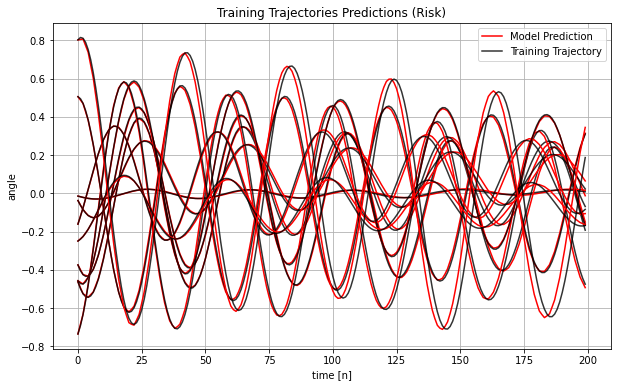

In [9]:
model = experiment_results['tuned_model']

plt.figure(figsize=(10, 6))
for idx, traj in enumerate(training_data):
    traj_pred = model.solve_ivp(
        traj.states[0], 
        inputs=traj.inputs, 
        teval=traj.times
    )
    plt.plot(traj_pred.states[:, 0], 'r', label='Model Prediction' if idx == 0 else None)
    plt.plot(traj.states[:, 0], 'k', alpha=0.8, label='Training Trajectory' if idx == 0 else None)
    
plt.xlabel("time [n]")
plt.ylabel("angle")
plt.grid()
plt.legend()
plt.title("Training Trajectories Predictions (Risk)")
plt.show()

In [10]:
# create a test inout signal for the system (different than training)
test_inp = np.sin(np.linspace(0, 10, 200))

# simulate using the learned model
iv = [0.5, 0.1]
trajectory = model.solve_ivp(
    initial_state=iv,
    inputs=test_inp,
    teval=teval,
)

No handles with labels found to put in legend.


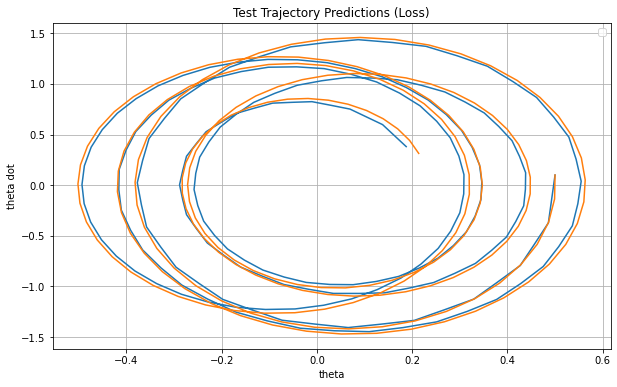

In [11]:
plt.figure(figsize=(10, 6))

# simulate the ground truth for comparison
true_trajectory = pendulum_sys.solve_ivp(
    initial_state=iv,
    inputs=test_inp,
    teval=teval,
)

# plot the results
plt.plot(*trajectory.states.T)
plt.plot(*true_trajectory.states.T)

plt.xlabel("theta")
plt.ylabel("theta dot")
plt.grid()
plt.legend()
plt.title("Test Trajectory Predictions (Loss)")
plt.show()